In [1]:
# %% [markdown]
# Pure Symphainetic Dual-Field Classifier (No Backprop)

# %%
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(123)
torch.set_grad_enabled(False)  # <-- no autograd anywhere


torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [2]:
# %%
def load_sklearn_dataset(name="breast_cancer", test_size=0.3):
    name = name.lower()
    if name == "iris":
        data = datasets.load_iris()
    elif name in ["breast_cancer", "brc", "cancer"]:
        data = datasets.load_breast_cancer()
    elif name == "wine":
        data = datasets.load_wine()
    elif name == "digits":
        data = datasets.load_digits()
    elif name == "moons":
        X, y = datasets.make_moons(n_samples=1000, noise=0.2, random_state=0)
        data = type("D", (), {})()
        data.data = X
        data.target = y
    else:
        raise ValueError(f"Unknown dataset name: {name}")

    X = data.data
    y = data.target

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=123, stratify=y
    )

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test  = torch.tensor(X_test,  dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test  = torch.tensor(y_test,  dtype=torch.long)

    num_classes = int(y_train.max().item() + 1)
    input_dim = X_train.shape[1]

    return X_train, y_train, X_test, y_test, num_classes, input_dim

DATASET_NAME = "breast_cancer"   # "iris", "wine", "digits", "moons", ...
X_train, y_train, X_test, y_test, num_classes, input_dim = load_sklearn_dataset(DATASET_NAME)

print(f"Dataset: {DATASET_NAME}")
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")
print(f"Input dim: {input_dim}, Num classes: {num_classes}")


Dataset: breast_cancer
Train size: 398, Test size: 171
Input dim: 30, Num classes: 2


In [3]:
class DualField(nn.Module):
    """
    Dual field (proto-Sympha-style):

      X ∈ R^{B×D} → S ∈ R^{B×d}, F ∈ R^{D×d}

    Dynamics:
      S_{t+1} = g(S_t A_s + X F_t W_psi^T)
      F_{t+1} = g(F_t A_f + X^T S_t W_phi^T)

    Structural couplings are fixed. Encoder S_init and classifier are plastic.
    """

    def __init__(self, D, d=16, T=3,
                 alpha=1.0, beta=1.0, gamma=1.0,
                 nonlin="tanh", device="cpu"):
        super().__init__()

        self.D = D
        self.d = d
        self.T = T
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = torch.device(device)

        # --- fixed structural couplings ---
        self.A_s   = nn.Linear(d, d, bias=False)
        self.A_f   = nn.Linear(d, d, bias=False)
        self.W_psi = nn.Linear(d, d, bias=False)  # F → S
        self.W_phi = nn.Linear(d, d, bias=False)  # S → F

        with torch.no_grad():
            for m in [self.A_s, self.A_f, self.W_psi, self.W_phi]:
                m.weight.uniform_(-0.1, 0.1)

        # --- plastic encoder: X → S0 ---
        self.S_init = nn.Linear(D, d, bias=False)
        with torch.no_grad():
            self.S_init.weight.uniform_(-0.1, 0.1)

        # nonlinearity
        if nonlin == "tanh":
            self.g = torch.tanh
        elif nonlin == "relu":
            self.g = F.relu
        else:
            raise ValueError("nonlin must be 'tanh' or 'relu'")

    def forward(self, X):
        """
        X: (B × D)
        Returns: S, F_field, F_int
        """
        X = X.to(self.device)
        B, D = X.shape
        assert D == self.D

        device = self.device

        # plastic encoder
        S = self.g(self.S_init(X))

        # fresh feature field
        F_field = torch.randn(D, self.d, device=device) * 0.1

        X_t = X.t()  # (D × B)

        # --- dual-field relaxation ---
        for _ in range(self.T):
            # sample update
            S_new = self.A_s(S)
            SF = X @ F_field          # (B × d)
            SF = self.W_psi(SF)
            S  = self.g(S_new + SF)

            # feature update
            F_new = self.A_f(F_field)
            FS = X_t @ S              # (D × d)
            FS = self.W_phi(FS)
            F_field = self.g(F_new + FS)

        # --- internal functional ---
        StS = S.t() @ S
        FtF = F_field.t() @ F_field
        I = torch.eye(self.d, device=device)

        SXT   = S.t() @ X
        SXT_F = SXT @ F_field

        term_S     = torch.norm(StS - I, p='fro')**2
        term_F     = torch.norm(FtF - I, p='fro')**2
        term_align = torch.norm(SXT_F, p='fro')**2

        F_int = - self.alpha * term_S \
                - self.beta  * term_F \
                + self.gamma * term_align

        return S, F_field, F_int


In [4]:
# %%
BATCH_SIZE = 64

train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

def corrupt_labels(y, noise_rate=0.0, num_classes=None, device=None):
    """Symmetric label noise (used only if you want it)."""
    if noise_rate <= 0.0:
        return y
    if num_classes is None:
        num_classes = int(y.max().item() + 1)
    if device is None:
        device = y.device

    y = y.clone()
    mask = torch.rand_like(y.float(), device=device) < noise_rate
    random_labels = torch.randint(0, num_classes, size=y.shape, device=device)
    y[mask] = random_labels[mask]
    return y


In [5]:
class FullSymphaClassifier:
    """
    Full Sympha chain (no backprop):

      X --(plastic encoder S_init)--> S0 --(fixed dual field)--> S
                                     |
                                     +--(plastic W_out)--> logits

    Learning:
      - S_init updated Hebbian from (X, S)
      - W_out updated Hebb/anti-Hebb from (S, y, p)

    Couplings A_s, A_f, W_psi, W_phi are structural and NEVER trained.
    """

    def __init__(self, D, num_classes, d=16, T=3,
                 alpha=1.0, beta=1.0, gamma=1.0,
                 eta_enc_phi=0.05, eta_enc_psi=0.01,
                 eta_phi=0.2, eta_psi=0.1,
                 nonlin="tanh", device="cpu"):
        self.device = torch.device(device)
        self.num_classes = num_classes
        self.d = d

        self.field = DualField(
            D, d=d, T=T,
            alpha=alpha, beta=beta, gamma=gamma,
            nonlin=nonlin, device=device
        ).to(self.device)

        # classifier W_out: S -> logits
        self.W_out = torch.randn(d, num_classes, device=self.device) * 0.1

        # learning rates
        self.eta_phi = eta_phi          # Hebb for W_out
        self.eta_psi = eta_psi          # anti-Hebb for W_out
        self.eta_enc_phi = eta_enc_phi  # Hebb for encoder
        self.eta_enc_psi = eta_enc_psi  # anti-Hebb / decay for encoder

    def forward(self, X):
        """
        X: (B x D)
        Returns:
          logits, S, F, F_int
        """
        X = X.to(self.device)
        S, F_field, F_int = self.field(X)
        logits = S @ self.W_out
        return logits, S, F_field, F_int

    def update_readout(self, S, y):
        """
        Hebb/anti-Hebb update on readout W_out:

          ΔW_out = η_φ * S^T y_onehot  -  η_ψ * S^T p

        where p = softmax(logits).
        """
        B = S.size(0)
        K = self.num_classes

        y_onehot = F.one_hot(y, num_classes=K).float().to(self.device)

        logits = S @ self.W_out
        p = F.softmax(logits, dim=1)

        dW_phi = (S.t() @ y_onehot) / B
        dW_psi = (S.t() @ p)        / B

        self.W_out += self.eta_phi * dW_phi
        self.W_out -= self.eta_psi * dW_psi

    def update_encoder(self, X, S):
        """
        Hebbian encoder update for S_init:

          S0 = S_init(X), we want S_init to align X with current S.

        Local rule:

          ΔS_init ≈ η_enc_φ * X^T S / B  -  η_enc_ψ * S_init.weight

        First term: Hebbian (correlation of inputs and current sample field).
        Second term: anti-Hebb / decay to avoid blow-up.
        """
        X = X.to(self.device)
        B, D = X.shape
        d = self.d

        W_enc = self.field.S_init.weight  # (d x D) in PyTorch layout
        # careful with shapes: S_init: out=d, in=D => weight shape (d, D)

        # X: (B x D), S: (B x d)
        # we want X^T S: (D x d), then transpose to (d x D) to match weight
        XS = X.t() @ S   # (D x d)
        dW_phi = XS.t() / B  # (d x D)

        # simple decay term
        dW_psi = W_enc

        with torch.no_grad():
            W_enc += self.eta_enc_phi * dW_phi
            W_enc -= self.eta_enc_psi * dW_psi


In [6]:
def train_epoch_full_sympha(model, loader, noise_rate=0.0):
    model.field.eval()  # field is structural; no train/eval difference for it

    total_ce = 0.0
    total = 0
    correct = 0
    F_int_sum = 0.0
    n_batches = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(model.device)
        y_batch = y_batch.to(model.device)

        # optionally corrupt labels for the monitoring CE, not for Hebb
        y_noisy = corrupt_labels(
            y_batch, noise_rate=noise_rate,
            num_classes=model.num_classes,
            device=model.device
        )

        # forward
        logits, S, F_field, F_int = model.forward(X_batch)

        # CE JUST FOR MONITORING
        ce = F.cross_entropy(logits, y_noisy)

        # Full Sympha weight updates (purely local)
        #   - readout uses clean labels
        model.update_readout(S, y_batch)
        #   - encoder uses (X, S)
        model.update_encoder(X_batch, S)

        # stats
        B = X_batch.size(0)
        total_ce += ce.item() * B
        total += B
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()

        F_int_sum += F_int.item()
        n_batches += 1

    avg_ce = total_ce / total
    acc = 100.0 * correct / total
    avg_F_int = F_int_sum / max(n_batches, 1)

    return avg_ce, acc, avg_F_int


@torch.no_grad()
def eval_epoch_full_sympha(model, loader):
    model.field.eval()
    total = 0
    correct = 0
    for X_batch, y_batch in loader:
        X_batch = X_batch.to(model.device)
        y_batch = y_batch.to(model.device)
        logits, S, F_field, F_int = model.forward(X_batch)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += X_batch.size(0)
    return 100.0 * correct / total


In [7]:
def apply_freezing_schedule(model, epoch, max_epoch):
    """
    Epoch-based schedule for Sympha plasticity with ψ annealing.

    - φ: kept in 3 phases (full, slow, encoder-frozen) as before.
    - ψ: same base values per phase, BUT multiplied by a factor that
         decays linearly from 1 → 0 over the course of training.

    This way:
      - early: ψ ~ base value (strong destabilization)
      - mid:  ψ reduced
      - late: ψ ~ 0 (almost pure φ, stable).
    """
    # linear annealing factor from 1 at epoch=1 to ~0 at epoch=max_epoch
    t = (epoch - 1) / max(1, (max_epoch - 1))
    psi_scale = max(0.0, 1.0 - t)   # 1 → 0

    # --- φ base schedule (as before) ---
    if epoch <= 10:
        # full plastic
        base_eta_enc_phi = 0.05
        base_eta_phi     = 0.20
        phase = "full plastic"
    elif epoch <= 20:
        # slowed plastic
        base_eta_enc_phi = 0.02
        base_eta_phi     = 0.10
        phase = "slow plastic"
    else:
        # encoder frozen, readout fine-tune
        base_eta_enc_phi = 0.0
        base_eta_phi     = 0.02
        phase = "encoder frozen, readout fine-tune"

    # --- ψ base values (before annealing) ---
    base_eta_enc_psi = 0.02   # you can tweak these two
    base_eta_psi     = 0.10

    # --- apply schedule: φ from phase, ψ = base * psi_scale ---
    model.eta_enc_phi = base_eta_enc_phi
    model.eta_phi     = base_eta_phi

    model.eta_enc_psi = base_eta_enc_psi * psi_scale
    model.eta_psi     = base_eta_psi     * psi_scale

    return phase, psi_scale


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

NUM_EPOCHS = 30
NOISE_RATE = 0.2

model = FullSymphaClassifier(
    D=input_dim,
    num_classes=num_classes,
    d=16,
    T=3,
    alpha=1.0,
    beta=1.0,
    gamma=1.0,
    eta_enc_phi=0.05,   # initial; will be overwritten by schedule
    eta_enc_psi=0.02,
    eta_phi=0.2,
    eta_psi=0.1,
    nonlin="tanh",
    device=device,
)

F_int_hist = []
train_acc_hist = []
test_acc_hist = []
ce_hist = []
phase_hist = []
psi_scale_hist = []

for epoch in range(1, NUM_EPOCHS + 1):
    phase, psi_scale = apply_freezing_schedule(model, epoch, max_epoch=NUM_EPOCHS)
    phase_hist.append(phase)
    psi_scale_hist.append(psi_scale)

    avg_ce, train_acc, avg_F_int = train_epoch_full_sympha(
        model, train_loader, noise_rate=NOISE_RATE
    )
    test_acc = eval_epoch_full_sympha(model, test_loader)

    F_int_hist.append(avg_F_int)
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)
    ce_hist.append(avg_ce)

    # optional: renormalize readout to avoid logit blow-up
    with torch.no_grad():
        W = model.W_out
        col_norm = W.norm(dim=0, keepdim=True) + 1e-8
        model.W_out = W / col_norm

    print(f"Epoch {epoch:02d} [{phase}, psi_scale={psi_scale:.2f}] | "
          f"CE (monitor) {avg_ce:.4f} | "
          f"F_int {avg_F_int:.2e} | "
          f"Train Acc {train_acc:.2f}% | "
          f"Test Acc {test_acc:.2f}%")


Device: cpu
Epoch 01 [full plastic, psi_scale=1.00] | CE (monitor) 0.6027 | F_int 8.59e+07 | Train Acc 68.59% | Test Acc 77.78%
Epoch 02 [full plastic, psi_scale=0.97] | CE (monitor) 0.6482 | F_int 1.11e+08 | Train Acc 76.88% | Test Acc 91.23%
Epoch 03 [full plastic, psi_scale=0.93] | CE (monitor) 1.0677 | F_int 8.44e+07 | Train Acc 68.34% | Test Acc 93.57%
Epoch 04 [full plastic, psi_scale=0.90] | CE (monitor) 0.7658 | F_int 1.05e+08 | Train Acc 88.44% | Test Acc 80.12%
Epoch 05 [full plastic, psi_scale=0.86] | CE (monitor) 0.7015 | F_int 1.01e+08 | Train Acc 86.18% | Test Acc 92.98%
Epoch 06 [full plastic, psi_scale=0.83] | CE (monitor) 0.5975 | F_int 9.95e+07 | Train Acc 89.20% | Test Acc 92.98%
Epoch 07 [full plastic, psi_scale=0.79] | CE (monitor) 0.5989 | F_int 1.10e+08 | Train Acc 76.88% | Test Acc 91.81%
Epoch 08 [full plastic, psi_scale=0.76] | CE (monitor) 0.5185 | F_int 9.72e+07 | Train Acc 85.68% | Test Acc 92.40%
Epoch 09 [full plastic, psi_scale=0.72] | CE (monitor) 0.667

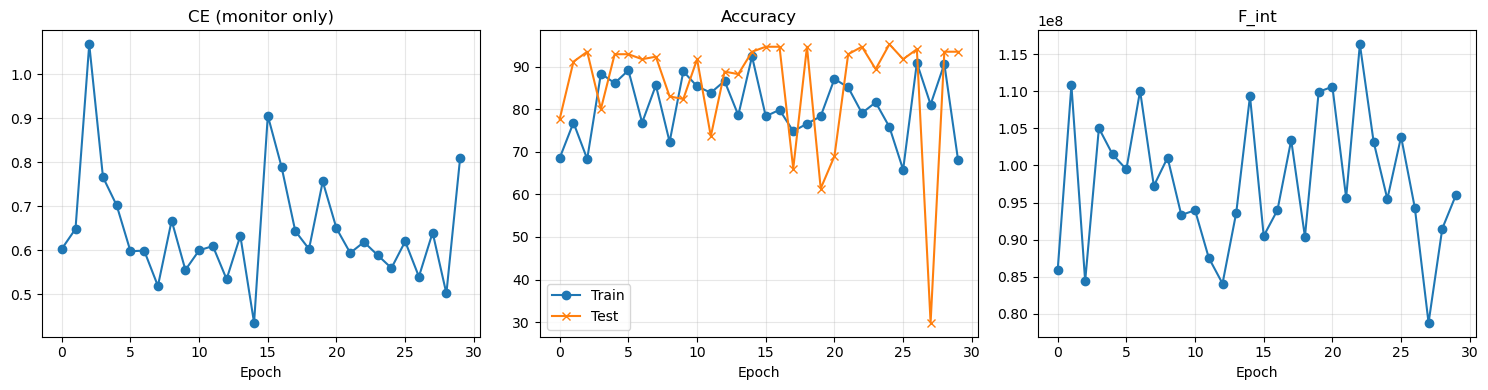

In [9]:
# %%
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(ce_hist, marker='o')
axs[0].set_title("CE (monitor only)")
axs[0].set_xlabel("Epoch")

axs[1].plot(train_acc_hist, marker='o', label="Train")
axs[1].plot(test_acc_hist, marker='x', label="Test")
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].legend()

axs[2].plot(F_int_hist, marker='o')
axs[2].set_title("F_int")
axs[2].set_xlabel("Epoch")

for ax in axs:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.plot(psi_scale_hist, marker='o')
plt.title("ψ annealing factor over epochs")
plt.xlabel("Epoch")
plt.grid(True, alpha=0.3)
plt.show()
